In [ ]:
!pip install tqdm==4.64.1 pandas==2.0.0 datasets==2.11.0 pandarallel==1.6.4 matplotlib==3.7.1 seaborn==0.12.2 transformers==4.28.0

In [1]:
import os

import pandas as pd
import seaborn as sns
from datasets import load_dataset
from matplotlib import pyplot as plt
from transformers import AutoTokenizer
from tqdm.notebook import tqdm
from pandarallel import pandarallel

sns.set()
pandarallel.initialize(progress_bar=True, nb_workers=os.cpu_count())

%matplotlib inline

None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


INFO: Pandarallel will run on 32 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [64]:
model_sizes = ['70m', '160m', '410m', '1b', '1.4b', '2.8b', '6.9b', '12b']
model_types = ['duped', 'deduped']
duped_dataset = load_dataset('EleutherAI/pythia-memorized-evals')

Found cached dataset parquet (/home/alvin/.cache/huggingface/datasets/EleutherAI___parquet/EleutherAI--pythia-memorized-evals-623aaa371a33821a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


  0%|          | 0/16 [00:00<?, ?it/s]

In [65]:
duped_dataset.keys()

dict_keys(['duped.1.4b', 'duped.2.8b', 'deduped.2.8b', 'duped.410m', 'duped.160m', 'duped.70m', 'deduped.160m', 'deduped.410m', 'duped.12b', 'duped.1b', 'duped.6.9b', 'deduped.12b', 'deduped.6.9b', 'deduped.1.4b', 'deduped.70m', 'deduped.1b'])

In [80]:
row_counts = []
row_counts_dict = {}

for model_type in model_types:
    for model_size in model_sizes:
        df = duped_dataset[f'{model_type}.{model_size}'].to_pandas()
        num_samples = len(df)
        row_counts.append((model_type, model_size, num_samples))
        row_counts_dict[(model_type, model_size)] = num_samples

row_counts_df = pd.DataFrame(row_counts, columns=['model_type', 'model_size', 'num_memorized_samples'])

In [81]:
row_counts_df

,model_type,model_size,num_memorized_samples
0,duped,70m,463953
1,duped,160m,689673
2,duped,410m,970341
3,duped,1b,1256141
4,duped,1.4b,1373722
5,duped,2.8b,1675077
6,duped,6.9b,2120969
7,duped,12b,2382326
8,deduped,70m,411448
9,deduped,160m,581195


In [78]:
sample_diffs = []

for model_size in model_sizes:
    duped_count = row_counts_dict[('duped', model_size)]
    deduped_count = row_counts_dict[('deduped', model_size)]
    difference_in_percentage = (duped_count - deduped_count) / duped_count * 100
    sample_diffs.append((model_size, difference_in_percentage))

sample_diffs_df = pd.DataFrame(sample_diffs, columns=['model_size', 'delta_percentage'])

In [79]:
sample_diffs_df

,model_size,delta_percentage
0,70m,11.316879
1,160m,15.728903
2,410m,16.417115
3,1b,17.774756
4,1.4b,23.703850
5,2.8b,19.095600
6,6.9b,20.777060
7,12b,21.454285


In [4]:
for model_name in tqdm(duped_dataset.keys()):
    print(f'Running on model {model_name}...')
    df = duped_dataset[model_name].to_pandas()
    df['tokens_index_concat'] = df['tokens'].parallel_apply(lambda t: '_'.join([f'{v}' for v in t]))
    df_agg = df.groupby('tokens_index_concat').agg({'index': 'nunique'}).reset_index()
    df_agg.sort_values('index', ascending=False).to_csv(f'unique_seq_freq_{model_name}.csv', index=False)

  0%|          | 0/16 [00:00<?, ?it/s]

Running on model duped.1.4b...


Running on model duped.2.8b...


Running on model deduped.2.8b...


Running on model duped.410m...


Running on model duped.160m...


Running on model duped.70m...


Running on model deduped.160m...


Running on model deduped.410m...


Running on model duped.12b...


Running on model duped.1b...


Running on model duped.6.9b...


Running on model deduped.12b...


Running on model deduped.6.9b...


Running on model deduped.1.4b...


Running on model deduped.70m...


Running on model deduped.1b...


In [5]:
model_sizes = ['70m', '160m', '410m', '1b', '1.4b', '2.8b', '6.9b', '12b']
model_types = ['duped', 'deduped']

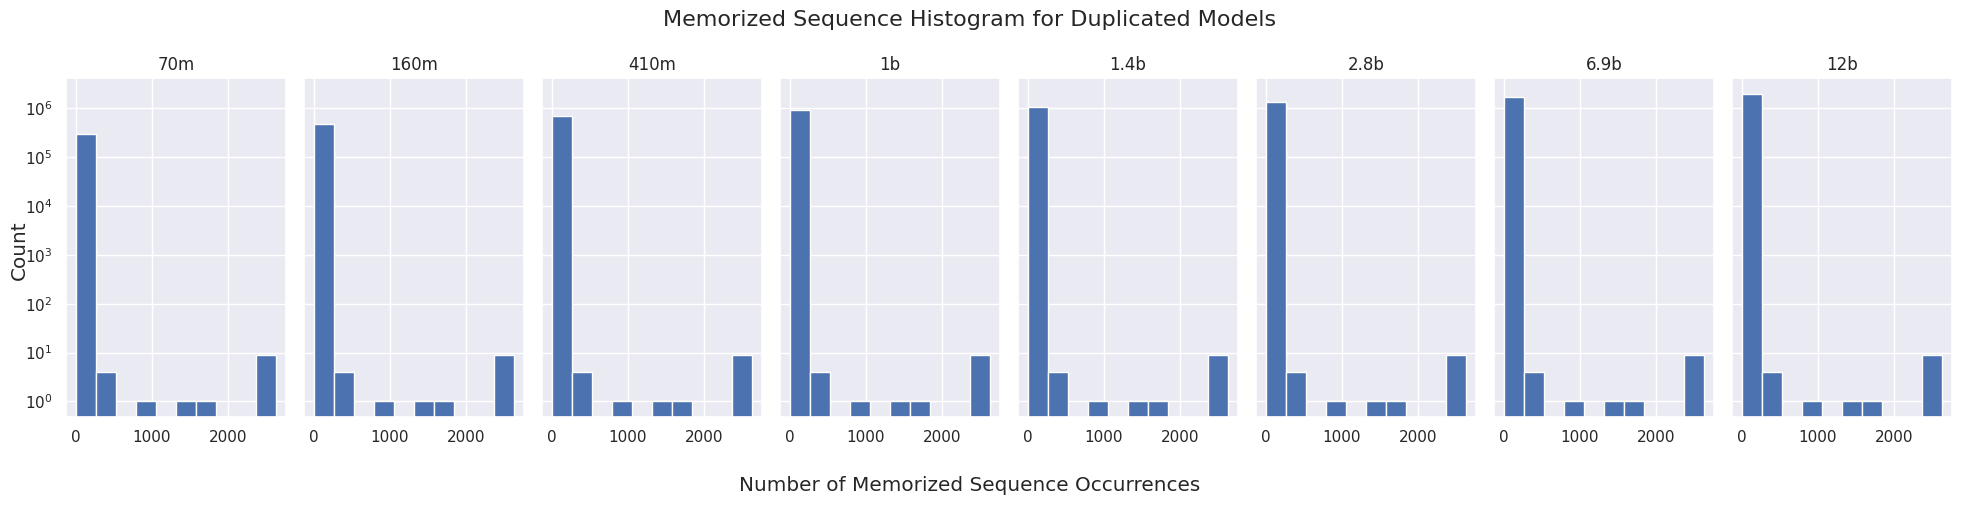

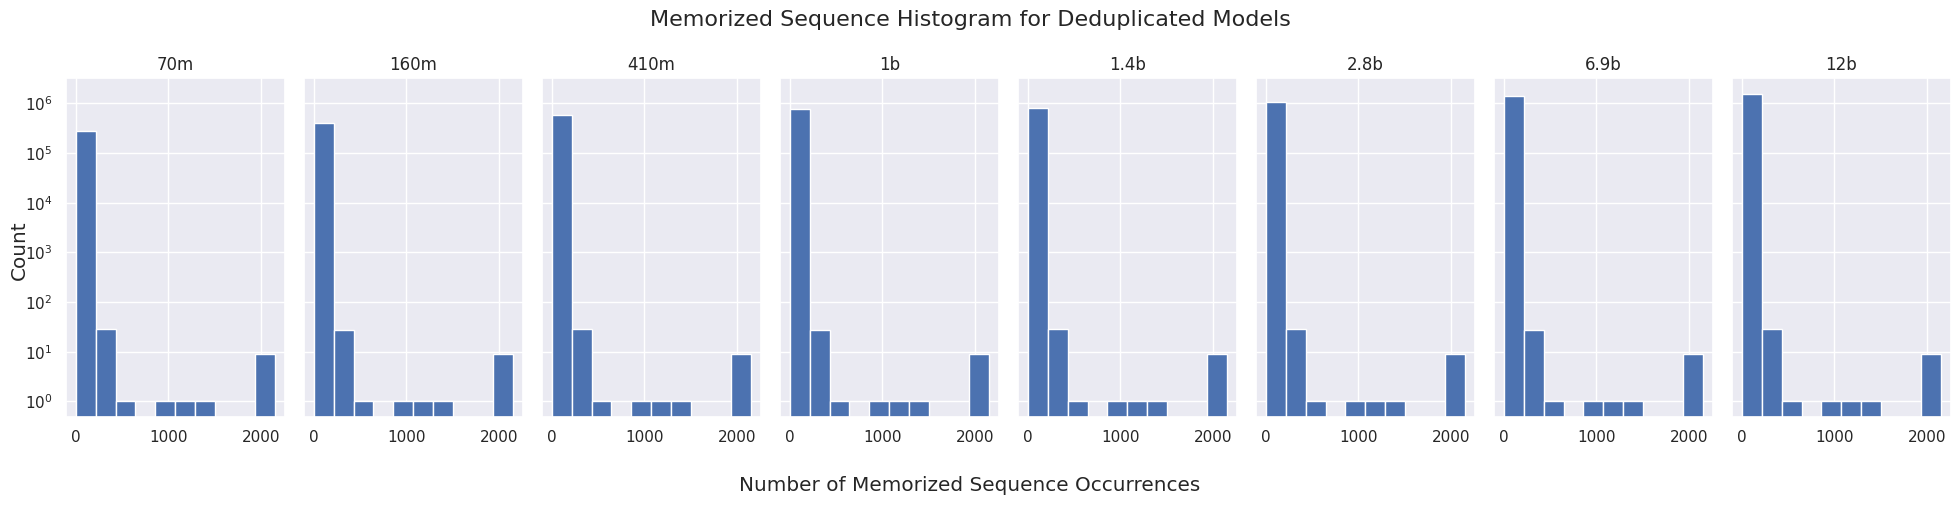

In [2]:
for model_type in model_types:
    formatted_model_type = 'Deduplicated' if model_type == 'deduped' else 'Duplicated'
    fig, axes = plt.subplots(nrows=1, ncols=len(model_sizes), figsize=(20, 5), sharey=True, tight_layout=True)

    for i, model_size in enumerate(model_sizes):
        freq_df = pd.read_csv(f'unique_seq_freq_{model_type}.{model_size}.csv')
        freq_df['index'].hist(ax=axes[i])
        axes[i].set_title(model_size)

    axes[0].set_yscale('log')
    fig.suptitle(f'Memorized Sequence Histogram for {formatted_model_type} Models', fontsize=16)
    fig.supxlabel('Number of Memorized Sequence Occurrences')
    fig.supylabel('Count')
    plt.show()

In [15]:
all_counts = []

for model_type in model_types:
    for model_size in tqdm(model_sizes):
        freq_df = pd.read_csv(f'unique_seq_freq_{model_type}.{model_size}.csv')
        counts_df = freq_df[freq_df['index'] > 1].reset_index(drop=True).rename(columns={'index': 'counts'})
        counts_df['model_size'] = model_size
        counts_df['model_type'] = model_type
        all_counts.append(counts_df)

all_counts_df = pd.concat(all_counts)

In [18]:
all_counts_df.head()

,tokens_index_concat,counts,model_size,model_type
0,8604_60_805_431_1019_8402_94_187_50262_61_2099...,2631,70m,duped
1,1019_8402_94_187_50262_61_2099_92_8798_94_187_...,2611,70m,duped
2,805_431_1019_8402_94_187_50262_61_2099_92_8798...,2610,70m,duped
3,8402_94_187_50262_61_2099_92_8798_94_187_50262...,2599,70m,duped
4,187_50262_61_2099_92_8798_94_187_50262_61_2099...,2589,70m,duped


Text(0.02, 0.5, 'Count')

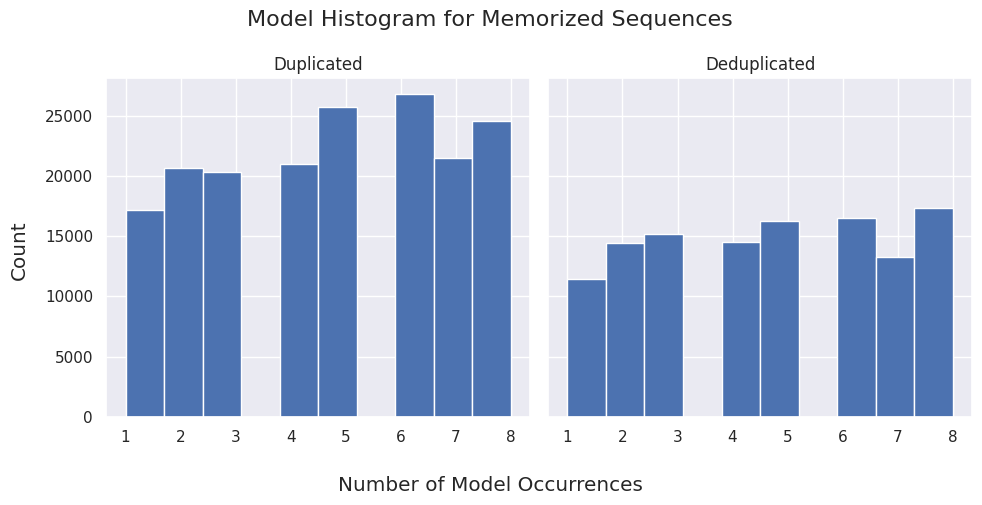

In [53]:
all_counts_agg_df = all_counts_df.groupby(['tokens_index_concat', 'model_type']).agg({'model_size': 'nunique'}).reset_index()
fig, axes = plt.subplots(nrows=1, ncols=len(model_types), figsize=(10, 5), sharey=True, tight_layout=True)

for i, model_type in enumerate(model_types):
    formatted_model_type = 'Deduplicated' if model_type == 'deduped' else 'Duplicated'
    all_counts_agg_df[all_counts_agg_df.model_type == model_type]['model_size'].hist(ax=axes[i])
    axes[i].set_title(formatted_model_type)

fig.suptitle(f'Model Histogram for Memorized Sequences', fontsize=16)
fig.supxlabel('Number of Model Occurrences')
fig.supylabel('Count')

Text(0.5, 1.0, 'Model Histogram for Memorized Sequences (All Models)')

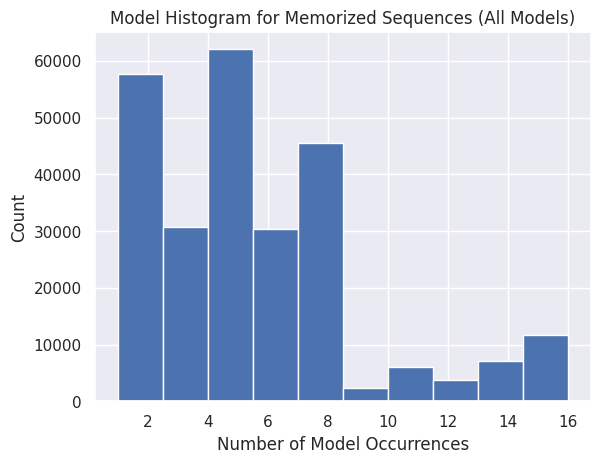

In [98]:
all_counts_agg_all_models_df = all_counts_df.groupby(['tokens_index_concat']).agg({'model_size': 'count'}).reset_index()

all_counts_agg_all_models_df['model_size'].hist()
plt.xlabel('Number of Model Occurrences')
plt.ylabel('Count')
plt.title('Model Histogram for Memorized Sequences (All Models)')

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
  'EleutherAI/pythia-70m-deduped',
  revision='step3000',
)

for _, row in all_counts_agg_all_models_df[all_counts_agg_all_models_df.model_size == 16].iterrows():
    frequency = row['tokens_index_concat']
    token_indices = list(map(lambda v: int(v), row.tokens_index_concat.split('_')))
    repeated_sequence = tokenizer.decode(token_indices)
    
    print('=================================================')
    print(repeated_sequence)
    print('=================================================')
    print()